In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [14]:
# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

## Correlation study

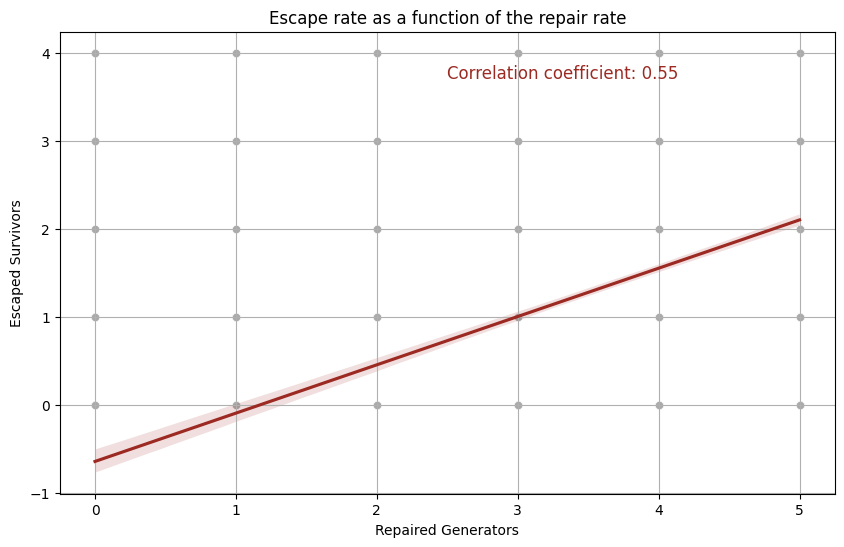

In [23]:
# Fit a linear regression model to get the slope
X = data['Nb Finished generators'].values.reshape(-1, 1)
y = data['Nb Escaped Survivors'].values
reg = LinearRegression().fit(X, y)
slope = reg.coef_[0]

# Create a scatter plot with a linear regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Nb Finished generators', y='Nb Escaped Survivors', data=data, color='darkgray')
sns.regplot(x='Nb Finished generators', y='Nb Escaped Survivors', data=data, scatter=False, color='#9C2A23')

# Add grid
plt.grid(True)

# Add labels and title
plt.xlabel('Repaired Generators')
plt.ylabel('Escaped Survivors')
plt.title('Escape rate as a function of the repair rate')

# Annotate the plot with the slope value
plt.text(0.5, 0.9, f'Correlation coefficient: {slope:.2f}', transform=plt.gca().transAxes, fontsize=12, color='#9C2A23')

# Display the plot
plt.show()


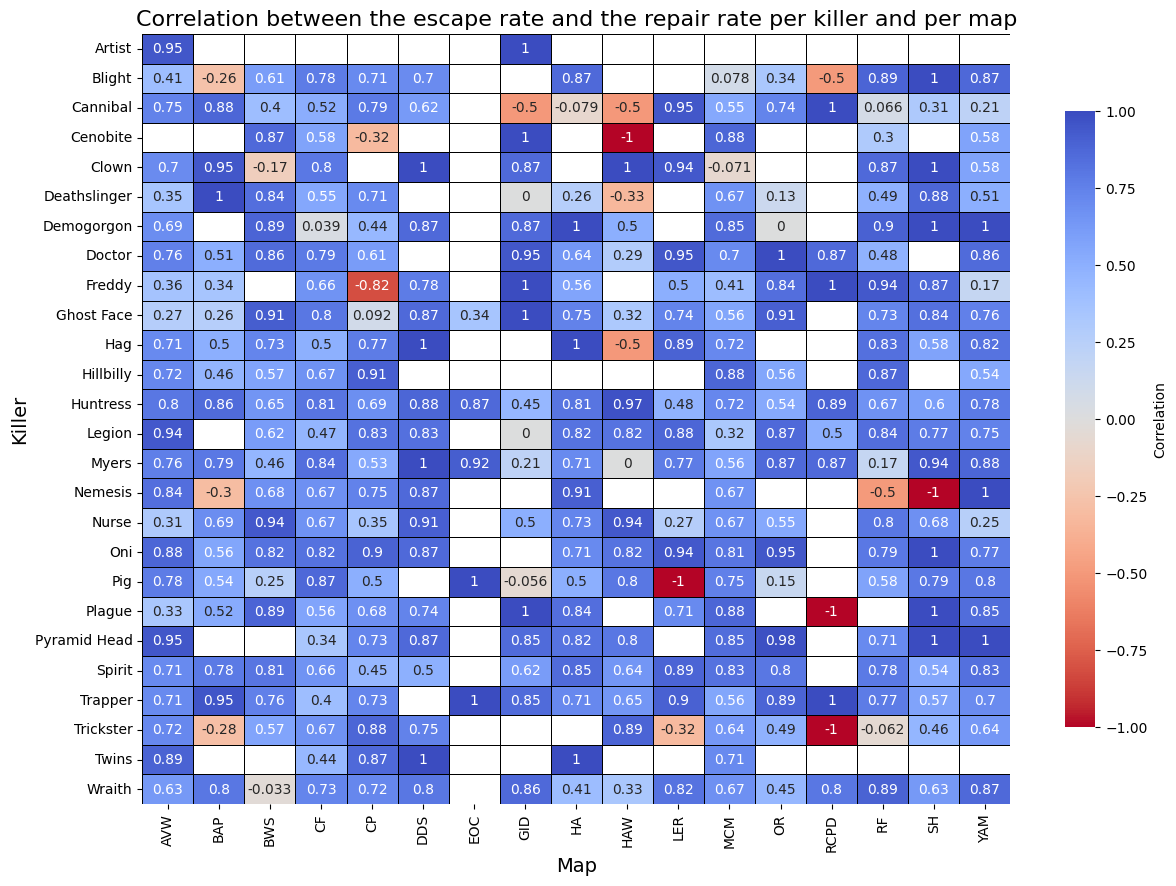

In [18]:
# Standardize the map names by stripping leading/trailing whitespace
data['Map'] = data['Map'].str.strip()

# Calculate Spearman correlation for each Killer and Map
cor_data = data.groupby(['Killer', 'Map']).apply(
    lambda group: pd.Series({
        'Correlation': group['Nb Finished generators'].corr(group['Nb Escaped Survivors'], method='spearman')
    })
).reset_index()

# Create a pivot table for the heatmap
cor_pivot = cor_data.pivot(index='Killer', columns='Map', values='Correlation')

# Plotting the heatmap
plt.figure(figsize=(14, 10))
ax = sns.heatmap(cor_pivot, annot=True, cmap='coolwarm_r', center=0, 
                 cbar_kws={'label': 'Correlation', 'orientation': 'vertical', 'shrink': 0.8},
                 linewidths=.5, linecolor='black')

# Customize the plot
ax.set_title('Correlation between the escape rate and the repair rate per killer and per map', fontsize=16)
ax.set_xlabel('Map', fontsize=14)
ax.set_ylabel('Killer', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Add a grid
ax.set_yticks([i + 0.5 for i in range(len(cor_pivot))], minor=True)
ax.set_xticks([i + 0.5 for i in range(len(cor_pivot.columns))], minor=True)
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='minor', size=0)

# Display the plot
plt.show()



## Escapes Prediction

Mean Squared Error: 1.2065972222222223
R^2 Score: 0.3659391883223333
Given features: 
    Map  Killer  Nb Finished generators
471  CP  Spirit                       3
Predicted number of survivors escaping for this round: 0.0
Actual number of survivors escaping for this round: 1


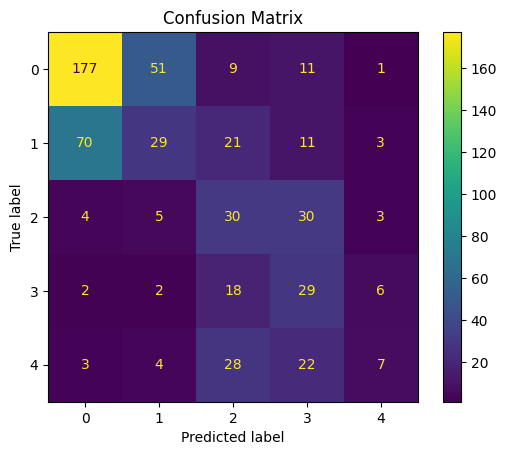

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       249
           1       0.32      0.22      0.26       134
           2       0.28      0.42      0.34        72
           3       0.28      0.51      0.36        57
           4       0.35      0.11      0.17        64

    accuracy                           0.47       576
   macro avg       0.38      0.39      0.37       576
weighted avg       0.48      0.47      0.46       576

In total 304 mistakes out of 576 samples


100%|██████████| 304/304 [00:00<00:00, 9713.33it/s]

Mistake 1:
Features: 
Map                           CP
Killer                    Spirit
Nb Finished generators         3
Name: 471, dtype: object
Actual: 1, Predicted: 0.0
--------------------------------------------------
Mistake 2:
Features: 
Map                           CF
Killer                    Wraith
Nb Finished generators         5
Name: 1453, dtype: object
Actual: 2, Predicted: 3.0
--------------------------------------------------
Mistake 3:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 3.0
--------------------------------------------------
Mistake 4:
Features: 
Map                          MCM
Killer                    Freddy
Nb Finished generators         5
Name: 1094, dtype: object
Actual: 4, Predicted: 2.0
--------------------------------------------------
Mistake 5:
Features: 
Map                           OR
Killer                    Spirit
Nb Finished

In [21]:
# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Comments', 'Nb Hatch escapes', 'SBMM', 'Season'])
target = data['Nb Escaped Survivors']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test).round().clip(0, 4)  # to have an integer between 0 and 4 as output

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Example prediction
example = X_test.iloc[0:1]
predicted_escapees = model.predict(example).round().clip(0, 4)
actual_escapees = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping for this round: {predicted_escapees[0]}')
print(f'Actual number of survivors escaping for this round: {actual_escapees}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(model, 'dbd_survivor_prediction_model.pkl')


from tqdm import tqdm
# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Exit Gate Escapes (only!) Prediction

Mean Squared Error: 1.1006944444444444
R^2 Score: 0.46811770668872754
Given features: 
    Map  Killer  Nb Finished generators
471  CP  Spirit                       3
Predicted number of survivors escaping through exit gates for this round: 0.0
Actual number of survivors escaping through exit gates for this round: 0


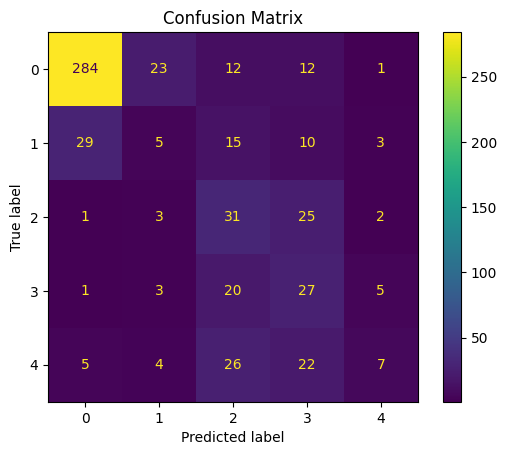

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       332
           1       0.13      0.08      0.10        62
           2       0.30      0.50      0.37        62
           3       0.28      0.48      0.36        56
           4       0.39      0.11      0.17        64

    accuracy                           0.61       576
   macro avg       0.40      0.41      0.37       576
weighted avg       0.63      0.61      0.61       576

In total 222 mistakes out of 576 samples


100%|██████████| 222/222 [00:00<00:00, 9257.84it/s]

Mistake 1:
Features: 
Map                           CF
Killer                    Wraith
Nb Finished generators         5
Name: 1453, dtype: object
Actual: 2, Predicted: 3.0
--------------------------------------------------
Mistake 2:
Features: 
Map                             SH
Killer                    Huntress
Nb Finished generators           5
Name: 2377, dtype: object
Actual: 0, Predicted: 3.0
--------------------------------------------------
Mistake 3:
Features: 
Map                          MCM
Killer                    Freddy
Nb Finished generators         5
Name: 1094, dtype: object
Actual: 4, Predicted: 2.0
--------------------------------------------------
Mistake 4:
Features: 
Map                          GID
Killer                    Wraith
Nb Finished generators         5
Name: 368, dtype: object
Actual: 4, Predicted: 2.0
--------------------------------------------------
Mistake 5:
Features: 
Map                         BAP
Killer                    Clown
Nb Finished g

In [19]:
# Load the dataset
data = pd.read_csv('Dead by Daylight data.csv')

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = np.round(model.predict(X_test)).clip(0, 4)  # to have an integer between 0 and 4 as output

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = np.round(model.predict(example)).clip(0, 4)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(model, 'dbd_exit_gate_escape_prediction_model.pkl')


from tqdm import tqdm
# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


## Exit Gates (only!) escapes prediction with 'Killer DC' filtering

Mean Squared Error: 1.1345794392523365
R^2 Score: 0.47195419792713433
Given features: 
    Map  Killer  Nb Finished generators
491  HA  Doctor                       2
Predicted number of survivors escaping through exit gates for this round: 0.0
Actual number of survivors escaping through exit gates for this round: 0


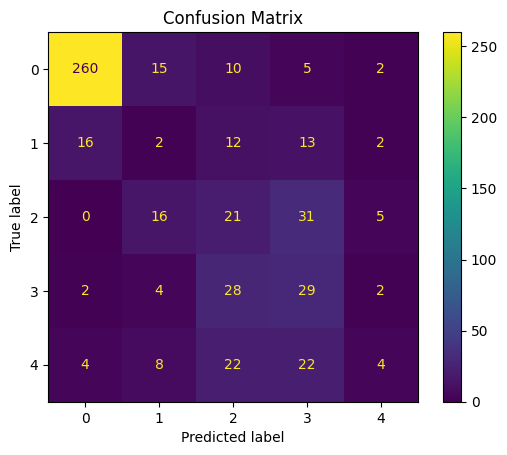

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       292
           1       0.04      0.04      0.04        45
           2       0.23      0.29      0.25        73
           3       0.29      0.45      0.35        65
           4       0.27      0.07      0.11        60

    accuracy                           0.59       535
   macro avg       0.35      0.35      0.33       535
weighted avg       0.60      0.59      0.59       535

In total 219 mistakes out of 535 samples


100%|██████████| 219/219 [00:00<00:00, 9808.25it/s]

Mistake 1:
Features: 
Map                           RF
Killer                    Legion
Nb Finished generators         5
Name: 1884, dtype: object
Actual: 4, Predicted: 3.0
--------------------------------------------------
Mistake 2:
Features: 
Map                           RF
Killer                    Spirit
Nb Finished generators         5
Name: 1982, dtype: object
Actual: 2, Predicted: 1.0
--------------------------------------------------
Mistake 3:
Features: 
Map                          BWS
Killer                    Wraith
Nb Finished generators         3
Name: 2661, dtype: object
Actual: 4, Predicted: 0.0
--------------------------------------------------
Mistake 4:
Features: 
Map                           CF
Killer                    Freddy
Nb Finished generators         5
Name: 913, dtype: object
Actual: 0, Predicted: 4.0
--------------------------------------------------
Mistake 5:
Features: 
Map                          CF
Killer                    Clown
Nb Finished generat

In [27]:
# Filter out matches where 'Comments' contains 'Killer DC'
data = data[~data['Comments'].str.contains('Killer DC', na=False)]

# Create the new target variable: number of survivors escaping through exit gates
data['Nb Exit Gate Escapes'] = data['Nb Escaped Survivors'] - data['Nb Hatch escapes']

# Define features and target
features = data.drop(columns=['Nb Escaped Survivors', 'Nb Hatch escapes', 'Comments', 'SBMM', 'Season', 'Nb Exit Gate Escapes'])
target = data['Nb Exit Gate Escapes']

# Identify categorical columns
categorical_cols = features.select_dtypes(include=['object']).columns.tolist()

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = np.round(model.predict(X_test)).clip(0, 4)  # to have an integer between 0 and 4 as output

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Example prediction
example = X_test.iloc[0:1]
predicted_exit_gate_escapes = np.round(model.predict(example)).clip(0, 4)
actual_exit_gate_escapes = y_test.iloc[0]
print(f'Given features: \n{example}')
print(f'Predicted number of survivors escaping through exit gates for this round: {predicted_exit_gate_escapes[0]}')
print(f'Actual number of survivors escaping through exit gates for this round: {actual_exit_gate_escapes}')

# Confusion Matrix
class_names = np.arange(0, 5)
conf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(model, 'dbd_exit_gate_escape_prediction_model_no_killer_dc.pkl')

# Error analysis
err = []
for i in range(len(y_test)):
    if y_test.iloc[i] != y_pred[i]:
        err.append(i)

print(f'In total {len(err)} mistakes out of {len(y_test)} samples')

for i in tqdm(range(len(err))):
    index = err[i]
    print(f'Mistake {i+1}:')
    print(f'Features: \n{X_test.iloc[index]}')
    print(f'Actual: {y_test.iloc[index]}, Predicted: {y_pred[index]}')
    print('-' * 50)


Predict a loss or a win!!